In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from agnpy.absorption import Absorption
from agnpy.targets import SphericalShellBLR, lines_dictionary

/home/pgliwny/anaconda3/envs/agn/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


This notebook presents how to use the multi-layer BLR model, which considers 27 BLR lines.

In [2]:
SUM_RATIO_LINES_BLR = 30.652

def get_absor_blrs(E, L_disk, R_line, r_blob_bh, z):
    
    """"
    Function to calculate absorption in BLR shells.
    Radius and luminosity are normalized to Hbeta
    Parameters
    ----------
    E: numpy array 
            Energy array with unit
    L_disk : astropy.units.Quantity
            Luminosity of the disk whose radiation is being reprocessed by the BLR
    R_line astropy.units.Quantity
            radius of the BLR spherical shell
    r_blob_bh : astropy.units.Quantity
            distance between the Broad Line Region and the blob
    z : float
            redshift of the source
    """
    nu = E.to("Hz", equivalencies=u.spectral())
    XI_LINE = 0.1
    blrs=dict()
    ec_blrs=dict()
    tau_z_all = np.zeros(nu.shape)
    for line in list(lines_dictionary.keys()):
        xi_line_this=lines_dictionary[line]['L_Hbeta_ratio']
        xi_line = (xi_line_this*XI_LINE)/SUM_RATIO_LINES_BLR
        R_line_this=R_line*lines_dictionary[line]['R_Hbeta_ratio']
        blrs[line] = SphericalShellBLR(L_disk, xi_line, line, R_line_this)
        ec_blrs[line] = Absorption(blrs[line], r=r_blob_bh, z=z)
        tau_z_this = ec_blrs[line].tau_blr_cubepy(nu, eps_abs=1e-6)
        tau_z_all+=tau_z_this
    A_blr = get_absorbtion_tau(np.array(tau_z_all))
    return A_blr

def get_absorbtion_tau(tau):
    "Function return absorption"
    return np.exp(-tau)

def log_parabola(energy, amplitude, reference, alpha, beta):
    "Log Parabola model from gammapy"
    xx = energy / reference
    exponent = -alpha - beta * np.log(xx)
    return amplitude * np.power(xx, exponent)

In [3]:
E = np.logspace(-1, 1, 20)*u.TeV
lp = log_parabola(
    E,
    amplitude=1e-12/((u.cm**2)*(u.s)*(u.TeV)),
    reference=1 * u.TeV,
    alpha=2.3,
    beta=0.5
    )
sed = E*E*lp

In [4]:
%%time
# Set BLR parameters
L_disk=6e45*u.Unit("erg s-1")
R_line = 2.45*1e17*u.cm
r_blob_bh = 1e18*u.cm
z = 1
A = get_absor_blrs(E, L_disk, R_line, r_blob_bh, z)

/home/pgliwny/anaconda3/envs/agn/lib/python3.8/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 20.9 s, sys: 904 ms, total: 21.8 s
Wall time: 20.7 s


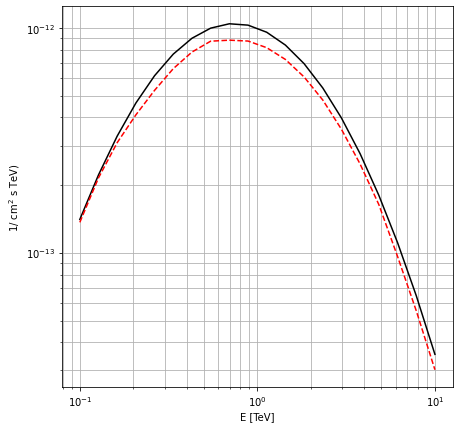

In [5]:
plt.figure(figsize=(7, 7))
plt.loglog(E, sed, 'k-')
plt.loglog(E, A*sed, 'r--')
plt.xlabel("E [TeV]")
plt.ylabel("1/ cm$^2$ s TeV)")
plt.grid(which='both')

# Function inside agnpy

This notebook demostrate how to use Absorption class to calcuare tau in BLR, which 26 shells following the Finke paper from 2016

In [5]:
def get_absorbtion_tau(tau):
    "Function return absorption"
    return np.exp(-tau)

In [6]:
# Set BLR parameters
L_disk=6e45*u.Unit("erg s-1")
R_line = 2.45*1e17*u.cm
r_blob_bh = 1e18*u.cm
z = 1
xi_line = 0.1

E = np.logspace(-1, 1, 20)*u.TeV
nu = E.to("Hz", equivalencies=u.spectral())

blr_one_line = SphericalShellBLR(L_disk, xi_line, "Hbeta", R_line)
abs_blr_one_line = Absorption(blr, r=r_blob_bh, z=z)


In [7]:
# Set BLR parameters
L_disk=6e45*u.Unit("erg s-1")
R_line = 2.45*1e17*u.cm
r_blob_bh = 1e18*u.cm
z = 1
xi_line = 0.1

E = np.logspace(-1, 1, 20)*u.TeV
nu = E.to("Hz", equivalencies=u.spectral())

blr = SphericalShellBLR(L_disk, xi_line, "Hbeta", R_line)
abs_blr = Absorption(blr, r=r_blob_bh, z=z)
tau_all_lines = abs_blr.tau_blr_all_lines_cubepy(nu)
A_blr = get_absorbtion_tau(np.array(tau_all_lines))

/home/pgliwny/anaconda3/envs/agn/lib/python3.8/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


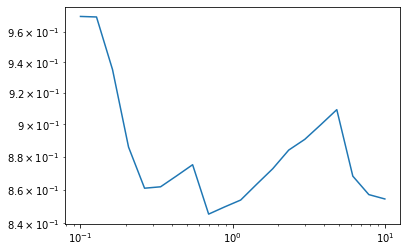

In [9]:
plt.loglog(E, A_blr)

In [11]:
abs_nu_agnpy = abs_blr.absorption(nu)

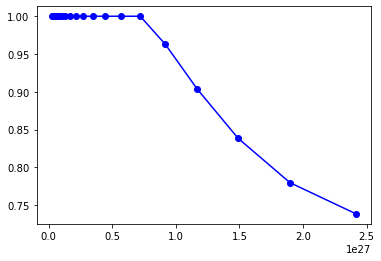

In [13]:
plt.plot(nu, abs_nu_agnpy, 'bo-')

In [22]:
E = np.logspace(-1, 1, 20)*u.TeV
lp = log_parabola(
    E,
    amplitude=1e-12/((u.cm**2)*(u.s)*(u.TeV)),
    reference=1 * u.TeV,
    alpha=2.3,
    beta=0.5
    )
sed = E*E*lp

In [23]:
# Set BLR parameters
L_disk=6e45*u.Unit("erg s-1")
R_line = 2.45*1e17*u.cm
r_blob_bh = 1e18*u.cm
z = 1
xi_line = 0.1

E = np.logspace(-1, 1, 20)*u.TeV
nu = E.to("Hz", equivalencies=u.spectral())

blr = SphericalShellBLR(L_disk, xi_line, "Hbeta", R_line)
abs_blr = Absorption(blr, r=r_blob_bh, z=z)
tau_all_lines = abs_blr.tau_blr_all_lines_cubepy(nu)
A_blr = get_absorbtion_tau(np.array(tau_all_lines))

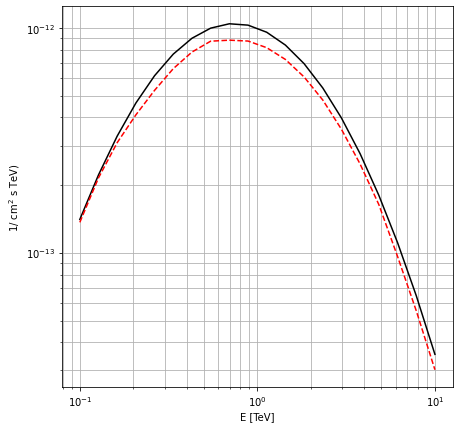

In [24]:
plt.figure(figsize=(7, 7))
plt.loglog(E, sed, 'k-')
plt.loglog(E, A_blr*sed, 'r--')
plt.xlabel("E [TeV]")
plt.ylabel("1/ cm$^2$ s TeV)")
plt.grid(which='both')